# HW7: Neural Transition-Based Dependency Parsing


In this exercise, you are going to build a deep learning model for Neural Networks Transition-Based Dependency Parsing. A dependency parser analyzes the grammatical structure of a sentence, establishing relationships between “head” words and words which modify those heads. Your implementation will be a transition-based parser, which incrementally builds up a parse one step at a time.

To complete this exercise, you will need to complete the code and build a deep learning model for dependency parsing. We will evaluate the model on the subset of Penn Treebank (annotated with Universal Dependencies). 

We provide the code for data preparation and the skeleton for PartialParse class. You do not need to understand the code outside of this notebook. 

This homework and the starter codes are adopt from Stanford University class CS224n.

This homework does not require you to use Google Colab or Google Cloud as the model is quite small (but you can still use it if you want)

## 1. Transition-Based Dependency Parsing

Your implementation will be a transition-based parser, which incrementally builds
up a parse one step at a time. At every step it maintains a partial parse, which is represented as follows:
- A stack of words that are currently being processed.
- A buffer of words yet to be processed.
- A list of dependencies predicted by the parser.

Initially, the stack only contains ROOT, the dependencies lists is empty, and the buffer contains all words
of the sentence in order. At each step, the parse applies a transition to the partial parse until its buffer is
empty and the stack is size 1. The following transitions can be applied:
- SHIFT: removes the first word from the buffer and pushes it onto the stack.
- LEFT-ARC: marks the second (second most recently added) item on the stack as a dependent of the
first item and removes the second item from the stack.
- RIGHT-ARC: marks the first (most recently added) item on the stack as a dependent of the second
item and removes the first item from the stack.

Your parser will decide among transitions at each state using a neural network classifier.

### TODO 1 (Written):
Go through the sequence of transitions needed for parsing the sentence “I parsed
this sentence correctly”. The dependency tree for the sentence is shown below. At each step, give the
configuration of the stack and buffer, as well as what transition was applied this step and what new
dependency was added (if any). The first three steps are provided below as an example.

<img src="https://github.com/ekapolc/NLP_2020/blob/master/HW7/images/img1.jpg?raw=true">

Complete the following table (double click the table and fill in the rest):

| stack    |  buffer |  new dependency | transition |
| :------: |:------: | :-------------: | :--------: |
| \[ROOT\]            | \[I, parsed, this, sentence, correctly\] |          | Initial Configuration |
| \[ROOT, I\]         | \[parsed, this, sentence, correctly\]    |          | SHIFT |
| \[ROOT, I, parsed\] | \[this, sentence, correctly\]            |          | SHIFT |
| \[ROOT, parsed\]    | \[this, sentence, correctly\]            | parsed→I | LEFT-ARC |
|\[ROOT, parsed, this\] | \[sentence, correctly\] | | SHIFT |
|\[ROOT, parsed, this, sentence\] | \[correctly\] | | SHIFT |
|\[ROOT, parsed, sentence\]|\[correctly\] | sentence→this |LEFT-ARC |
|\[ROOT, parsed]| \[correctly\]| parsed→sentence | RIGHT-ARC |
|\[ROOT, parsed, correctly\]| \[ \]| | SHIFT |
|\[ROOT, parsed\]|\[ \] | parsed→correctly | RIGHT-ARC|
|\[ROOT\] | \[ \]| ROOT→parsed | RIGHT-ARC|

### TODO 2 (Coding):
Implement the __\_\_init\_\___ and __parse_step__ functions in the PartialParse class. Your code must past both of the following tests.

In [ ]:
class PartialParse(object):
    def __init__(self, sentence):
        """Initializes this partial parse.

        Your code should initialize the following fields:
            self.stack: The current stack represented as a list with the top of the stack as the
                        last element of the list.
            self.buffer: The current buffer represented as a list with the first item on the
                         buffer as the first item of the list
            self.dependencies: The list of dependencies produced so far. Represented as a list of
                    tuples where each tuple is of the form (head, dependent).
                    Order for this list doesn't matter.

        The root token should be represented with the string "ROOT"

        Args:
            sentence: The sentence to be parsed as a list of words.
                      Your code should not modify the sentence.
        """
        # The sentence being parsed is kept for bookkeeping purposes. Do not use it in your code.
        self.sentence = sentence

        ### YOUR CODE HERE
        self.stack = ['ROOT']
        self.buffer = sentence[:]
        self.dependencies = []
        ### END YOUR CODE

    def parse_step(self, transition):
        """Performs a single parse step by applying the given transition to this partial parse

        Args:
            transition: A string that equals "S", "LA", or "RA" representing the shift, left-arc,
                        and right-arc transitions. You can assume the provided transition is a legal
                        transition.
        """
        ### YOUR CODE HERE
        if transition == "S":
            self.stack.append(self.buffer.pop(0))
        elif transition == "LA":
            dependent, head = self.stack[-2:]
            self.stack.pop(-2)
            self.dependencies.append((head, dependent))
        elif transition == "RA":
            head, dependent = self.stack[-2:]
            self.stack.pop(-1)
            self.dependencies.append((head, dependent))
        ### END YOUR CODE

    def parse(self, transitions):
        """Applies the provided transitions to this PartialParse

        Args:
            transitions: The list of transitions in the order they should be applied
        Returns:
            dependencies: The list of dependencies produced when parsing the sentence. Represented
                          as a list of tuples where each tuple is of the form (head, dependent)
        """
        for transition in transitions:
            self.parse_step(transition)
        return self.dependencies

In [ ]:
# Do not modify this code
def test_step(name, transition, stack, buf, deps,
              ex_stack, ex_buf, ex_deps):
    """Tests that a single parse step returns the expected output"""
    pp = PartialParse([])
    pp.stack, pp.buffer, pp.dependencies = stack, buf, deps

    pp.parse_step(transition)
    stack, buf, deps = (tuple(pp.stack), tuple(pp.buffer), tuple(sorted(pp.dependencies)))
    assert stack == ex_stack, \
        "{:} test resulted in stack {:}, expected {:}".format(name, stack, ex_stack)
    assert buf == ex_buf, \
        "{:} test resulted in buffer {:}, expected {:}".format(name, buf, ex_buf)
    assert deps == ex_deps, \
        "{:} test resulted in dependency list {:}, expected {:}".format(name, deps, ex_deps)
    print("{:} test passed!".format(name))


def test_parse_step():
    """Simple tests for the PartialParse.parse_step function
    Warning: these are not exhaustive
    """
    test_step("SHIFT", "S", ["ROOT", "the"], ["cat", "sat"], [],
              ("ROOT", "the", "cat"), ("sat",), ())
    test_step("LEFT-ARC", "LA", ["ROOT", "the", "cat"], ["sat"], [],
              ("ROOT", "cat",), ("sat",), (("cat", "the"),))
    test_step("RIGHT-ARC", "RA", ["ROOT", "run", "fast"], [], [],
              ("ROOT", "run",), (), (("run", "fast"),))


def test_parse():
    """Simple tests for the PartialParse.parse function
    Warning: these are not exhaustive
    """
    sentence = ["parse", "this", "sentence"]
    dependencies = PartialParse(sentence).parse(["S", "S", "S", "LA", "RA", "RA"])
    dependencies = tuple(sorted(dependencies))
    expected = (('ROOT', 'parse'), ('parse', 'sentence'), ('sentence', 'this'))
    assert dependencies == expected,  \
        "parse test resulted in dependencies {:}, expected {:}".format(dependencies, expected)
    assert tuple(sentence) == ("parse", "this", "sentence"), \
        "parse test failed: the input sentence should not be modified"
    print("parse test passed!")

In [ ]:
test_parse_step()
test_parse()

SHIFT test passed!
LEFT-ARC test passed!
RIGHT-ARC test passed!
parse test passed!


### TODO 3 (Coding):
Our network will predict which transition should be applied next to a partial parse. We could use it to parse a single sentence by applying predicted transitions until the parse is complete. However, neural networks run much more efficiently when making predictions about batches of data at a time (i.e., predicting the next transition for a many different partial parses simultaneously). We can parse sentences in minibatches with the following algorithm.

<img src="https://github.com/ekapolc/NLP_2020/blob/master/HW7/images/img2.jpg?raw=true">

Implement this algorithm in the minibatch parse function and run the following test.

In [ ]:
def minibatch_parse(sentences, model, batch_size):
    """Parses a list of sentences in minibatches using a model.

    Args:
        sentences: A list of sentences to be parsed (each sentence is a list of words)
        model: The model that makes parsing decisions. It is assumed to have a function
               model.predict(partial_parses) that takes in a list of PartialParses as input and
               returns a list of transitions predicted for each parse. That is, after calling
                   transitions = model.predict(partial_parses)
               transitions[i] will be the next transition to apply to partial_parses[i].
        batch_size: The number of PartialParses to include in each minibatch
    Returns:
        dependencies: A list where each element is the dependencies list for a parsed sentence.
                      Ordering should be the same as in sentences (i.e., dependencies[i] should
                      contain the parse for sentences[i]).
    """

    ### YOUR CODE HERE
    partial_parses = [PartialParse(sentence) for sentence in sentences]
    unfinished_parses = partial_parses[:]
    denpendencies = []
    while unfinished_parses != []:
        minibatch_parses = unfinished_parses[:batch_size]
        transitions = model.predict(minibatch_parses)

        for parse, transition in zip(minibatch_parses, transitions):
            parse.parse_step(transition)
            if len(parse.stack) < 2 and len(parse.buffer) < 1:
                unfinished_parses.remove(parse)
    
    dependencies = [p.dependencies for p in partial_parses]

    ### END YOUR CODE

    return dependencies

In [ ]:
# Do not modify this code
class DummyModel(object):
    """Dummy model for testing the minibatch_parse function
    First shifts everything onto the stack and then does exclusively right arcs if the first word of
    the sentence is "right", "left" if otherwise.
    """
    def predict(self, partial_parses):
        return [("RA" if pp.stack[1] is "right" else "LA") if len(pp.buffer) == 0 else "S"
                for pp in partial_parses]


def test_dependencies(name, deps, ex_deps):
    """Tests the provided dependencies match the expected dependencies"""
    deps = tuple(sorted(deps))
    assert deps == ex_deps, \
        "{:} test resulted in dependency list {:}, expected {:}".format(name, deps, ex_deps)


def test_minibatch_parse():
    """Simple tests for the minibatch_parse function
    Warning: these are not exhaustive
    """
    sentences = [["right", "arcs", "only"],
                 ["right", "arcs", "only", "again"],
                 ["left", "arcs", "only"],
                 ["left", "arcs", "only", "again"]]
    deps = minibatch_parse(sentences, DummyModel(), 2)
    test_dependencies("minibatch_parse", deps[0],
                      (('ROOT', 'right'), ('arcs', 'only'), ('right', 'arcs')))
    test_dependencies("minibatch_parse", deps[1],
                      (('ROOT', 'right'), ('arcs', 'only'), ('only', 'again'), ('right', 'arcs')))
    test_dependencies("minibatch_parse", deps[2],
                      (('only', 'ROOT'), ('only', 'arcs'), ('only', 'left')))
    test_dependencies("minibatch_parse", deps[3],
                      (('again', 'ROOT'), ('again', 'arcs'), ('again', 'left'), ('again', 'only')))
    print("minibatch_parse test passed!")

In [ ]:
test_minibatch_parse()

minibatch_parse test passed!


## 2. Setup and Preprocessing

In [ ]:
!wget --no-check-certificate https://raw.githubusercontent.com/ekapolc/nlp_2020/master/HW7/HW7.zip 
!unzip HW7.zip

--2021-03-12 07:53:48--  https://raw.githubusercontent.com/ekapolc/nlp_2020/master/HW7/HW7.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39003291 (37M) [application/zip]
Saving to: ‘HW7.zip.1’

HW7.zip.1           100%[===================>]  37.20M  62.0MB/s    in 0.6s    

2021-03-12 07:53:49 (62.0 MB/s) - ‘HW7.zip.1’ saved [39003291/39003291]

Archive:  HW7.zip
replace HW7_parsing.ipynb? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
import sys
import os

sys.path.append('/content/utils')

In [ ]:
from utils.parser_utils import minibatches, load_and_preprocess_data

Preparing data. We will use a subset of Penn Treebank and pretrained embeddings in this task

We are now going to train a neural network to predict, given the state of the stack, buffer, and dependencies, which transition should be applied next. First, the model extracts a feature vector representing the current state. We will be using the feature set presented in the original neural dependency parsing paper: A Fast and Accurate Dependency Parser using Neural Networks. 

The function extracting these features has been implemented for you in parser_utils. This feature vector consists of a list of tokens (e.g., the last word in the stack, first word in the buffer, dependent of the second-to-last word in the stack if there is one, etc.). They can be represented as a list of integers.

In [ ]:
parser, embeddings, train_examples, dev_set, test_set = load_and_preprocess_data(True)

Loading data...
took 2.10 seconds
Building parser...
took 0.03 seconds
Loading pretrained embeddings...
took 2.39 seconds
Vectorizing data...
took 0.07 seconds
Preprocessing training data...
took 1.28 seconds


In [ ]:
print(len(train_examples), len(dev_set), len(test_set))

48390 500 500


In [ ]:
print(embeddings.shape)

(5157, 50)


Get the full batch of our subset data

In [ ]:
minibatch_gen = minibatches(train_examples, len(train_examples))
x_train, y_train = minibatch_gen.__next__()

In [ ]:
print(x_train.shape)
print(y_train.shape)

(48390, 36)
(48390, 3)


In [ ]:
# Sample features
print(x_train[0])

[4061  113 4063   87 5155 5155  472 5155 1168 5155 5155 5155 5155 5155
 5155 5155 5155 5155   55   41   39   46   83   83   43   83   39   83
   83   83   83   83   83   83   83   83]


## 3. Model

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input, Dense, Reshape, Dropout, Flatten, Conv1D, LSTM
from tensorflow.keras.optimizers import Adam

### TODO 4 (Coding):
Build and train a tensroflow keras model to predict an action for each state of of the input. This is a simple classification task. 
- The input and output of the model must match the dimention of x_train and y_train.
- The model must use the provided pretrained embeddings
- The model could comprise of only a feedforward layer and a dropout
- Training loss should be around 0.1 or below, and training categorical_accuracy above 0.94

In [ ]:
embeddings.shape[0]

5157

In [ ]:
model = Sequential()
# Write your code here
model.add(Embedding(embeddings.shape[0], embeddings.shape[1], weights=[embeddings], mask_zero=True))
model.add(Conv1D(filters=100, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(y_train.shape[1], activation='sigmoid'))

model.compile(optimizer=Adam(),
                loss='categorical_crossentropy',
                metrics=['acc'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 50)          257850    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 100)         25100     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 363,653
Trainable params: 363,653
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Write your code here
model.fit(x_train, y_train, epochs=10)

Epoch 1/10
1513/1513 [==============================] - 131s 84ms/step - loss: 0.6926 - acc: 0.6648
Epoch 2/10
1513/1513 [==============================] - 127s 84ms/step - loss: 0.2920 - acc: 0.8849
Epoch 3/10
1513/1513 [==============================] - 129s 85ms/step - loss: 0.2318 - acc: 0.9113
Epoch 4/10
1513/1513 [==============================] - 130s 86ms/step - loss: 0.1964 - acc: 0.9245
Epoch 5/10
1513/1513 [==============================] - 128s 84ms/step - loss: 0.1682 - acc: 0.9362
Epoch 6/10
1513/1513 [==============================] - 128s 84ms/step - loss: 0.1448 - acc: 0.9463
Epoch 7/10
1513/1513 [==============================] - 128s 85ms/step - loss: 0.1263 - acc: 0.9536
Epoch 8/10
1513/1513 [==============================] - 128s 84ms/step - loss: 0.1070 - acc: 0.9606
Epoch 9/10
1513/1513 [==============================] - 128s 84ms/step - loss: 0.1034 - acc: 0.9628
Epoch 10/10
1513/1513 [==============================] - 127s 84ms/step - loss: 0.0870 - acc: 0.9671

In [ ]:
model.save_weights('model_wt.h5')

## 4. Evaluation

For Dependency Parsing, we usually report attachment score of the model for evaluation. There are two possible metrics UAS and LAS.

### TODO 5 (Written and Coding):
Explain how attachment score is calculated and the difference between unlabeled attachment score (UAS) and labeled attachment score (LAS). Which one should we use here?

__Answer here__:
We can specify types for each dependencies such as 'root', 'nsubj', 'case' etc.<br>
LAS will count the correction if both predicted dependency and label of the dependency are correct
<br>
UAS will count the correction if only predicted dependency are correct
<br>
Thus, UAS >= LAS.
<br>
Since we did not train the model to predict label of the dependency, UAS is appropriate matric to evaluate our model performance.

Report the score using appropriate metric on dev_set and test_set. The function for calculating scores are provided in parser.parse and the dataset can be passed in as-is.

dev_score:

In [123]:
dev_results = parser.parse(dev_set, model, minibatch_parse)

In [125]:
print('dev_set scores = ' + str(dev_results[0]))

dev_set scores = 0.7299008581188037


test_score:

In [126]:
test_results = parser.parse(test_set, model, minibatch_parse)

In [127]:
print('test_set scores = ' + str(test_results[0]))

test_set scores = 0.7507148864592095


Also, print one sample sentence (in English) in the test set and its predicted dependencies from the model.
You can use __parser.id2tok\[word_id\]__ to lookup the word in English.

__Draw a picture of this sentence with arrows and upload it to my couseville__

In [185]:
# [parser.id2tok[i] for i in dev_set[0]['label'][1:]]

In [179]:
def print_sample_sentence(sentence_number = 1):
  sample_sentence = [parser.id2tok[w] for w in test_set[sentence_number]['word']]
  print('sentence')

  print(' '.join(sample_sentence))
  sample_dependencies = [(sample_sentence[pair[0]], sample_sentence[pair[1]]) for pair in test_results[1][sentence_number]]
  print('\npredicted dependencies')
  print(sample_dependencies)

  actual_dependencies = [(v, k) for k, v in enumerate(test_set[sentence_number]['head'])][1:]
  actual_dependencies = [(sample_sentence[pair[0]], sample_sentence[pair[1]]) for pair in actual_dependencies]
  print('\nactual dependencies')
  print(actual_dependencies)

In [180]:
print_sample_sentence(11)

sentence
<ROOT> when the dollar is in a <UNK> , even central banks ca n't stop it .

predicted dependencies
[('dollar', 'the'), ('<UNK>', 'a'), ('<UNK>', 'in'), ('banks', 'central'), ('stop', "n't"), ('stop', 'ca'), ('stop', 'banks'), ('stop', 'even'), ('stop', ','), ('stop', '<UNK>'), ('stop', 'is'), ('stop', 'dollar'), ('stop', 'when'), ('stop', 'it'), ('stop', '.'), ('<ROOT>', 'stop')]

actual dependencies
[('<UNK>', 'when'), ('dollar', 'the'), ('<UNK>', 'dollar'), ('<UNK>', 'is'), ('<UNK>', 'in'), ('<UNK>', 'a'), ('stop', '<UNK>'), ('stop', ','), ('banks', 'even'), ('banks', 'central'), ('stop', 'banks'), ('stop', 'ca'), ('stop', "n't"), ('<ROOT>', 'stop'), ('stop', 'it'), ('stop', '.')]


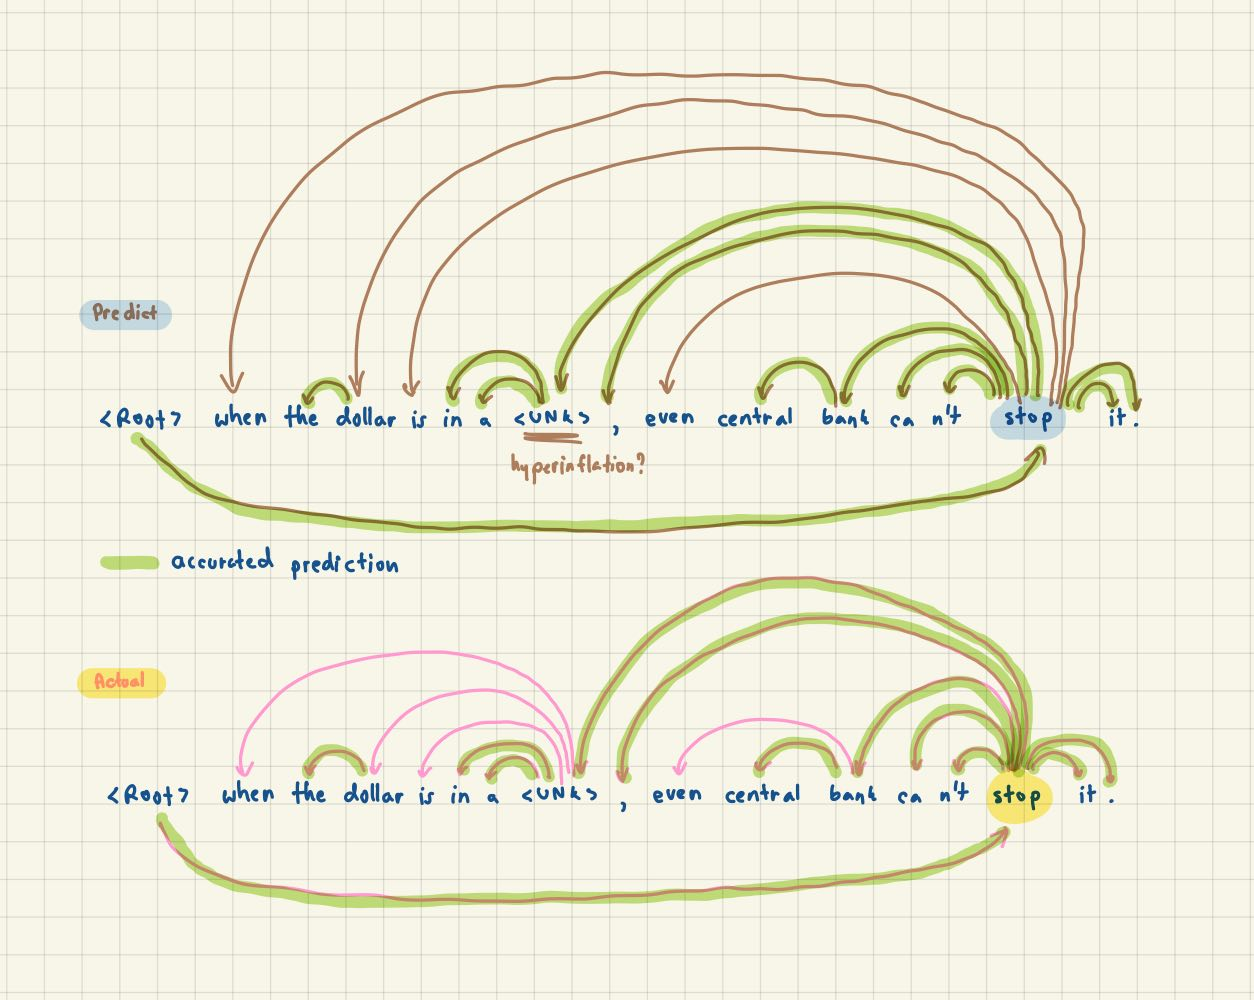